This study investigates the effectiveness of **Long Short-Term Memory (LSTM)** and **Gated Recurrent Unit (GRU)** models in classifying **coding** and **non-coding** DNA sequences within a metagenomic dataset related to lettuce microbiome (Study MGYS00000513). The data included **gene features, DNA sequences**, and **labels** indicating coding (1) or non-coding (0) status. 

Given the potential imbalance between coding and non-coding sequences, the **Synthetic Minority Oversampling Technique (SMOTE)** was employed to balance the dataset before training the models. This approach achieved an accuracy of 91% in distinguishing between coding and non-coding sequences, suggesting the potential of GRU for analyzing metagenomic data.

## Used Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, LSTM, Dense, GRU
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

## Import Data

In [3]:
df0 = pd.read_csv('/kaggle/input/coding-noncoding-dna-sequences/Coding_NonCoding_DNA_Sequences')
data_shuffled = df0.sample(frac=1, random_state=1)
data_shuffled.head(10)

,Unnamed: 0,gene_features,DNA_sequence,Target
60455,60455,MISEQ:128:000000000-A7920:1:2116:18663:4630_1:...,GCTCACGCGCTTCAAGGCTGCTCACCGCGAGGAGCAGCTCGAGCCA...,0
49650,49650,MISEQ:128:000000000-A7920:1:2105:14571:1816_1:...,GAGCTCACCCGGGATGCCGAAGAACGGCGAGACCGGGCGGGCGTCG...,0
31043,31043,MISEQ:128:000000000-A7920:1:1109:15231:15963_1...,CACCTGCCCGCTACTGACCGCTGGTGGACACCGAAACCGAATGGGG...,0
42092,42092,MISEQ:128:000000000-A7920:1:1117:15174:18638_1...,GCTACGAACTGACCGAGCCGCCGGAACACCGCAATCTGGACCGCTT...,0
10200,10200,MISEQ:128:000000000-A7920:1:1119:16225:2246_1:...,GTCGCGCGCTGGAAGAACGGCGAGATCGTGGAGGAGAACCTGTTCT...,1
8572,8572,MISEQ:128:000000000-A7920:1:1115:20973:18702_1...,CCCGGCCGGATGACGCACGGTTCGATTCCCGCATCGGTGCGCGAGC...,1
6384,6384,MISEQ:128:000000000-A7920:1:1112:14351:3335_1:...,CCCGGAACGGTGCGCGCAGGTCAATCATCGTTTAGCTTGGCTCGGT...,1
33505,33505,MISEQ:128:000000000-A7920:1:1111:7885:11265_1:...,ATACACGAGTCTGGACACAACTGCAATGCCAGCACAACCCCACGAA...,0
49120,49120,MISEQ:128:000000000-A7920:1:2104:18393:14064_1...,ATCCAACACCACCTCAAATCTGGTATTAAAACCAGCGTGATGACAG...,0
47404,47404,MISEQ:128:000000000-A7920:1:2103:9167:7933_1:N...,ATGCTTTCTTCATCACGTCCTCCAGGGGAAACCTCTGGCACACTAT...,0


In [4]:
data_shuffled.head()

,Unnamed: 0,gene_features,DNA_sequence,Target
60455,60455,MISEQ:128:000000000-A7920:1:2116:18663:4630_1:...,GCTCACGCGCTTCAAGGCTGCTCACCGCGAGGAGCAGCTCGAGCCA...,0
49650,49650,MISEQ:128:000000000-A7920:1:2105:14571:1816_1:...,GAGCTCACCCGGGATGCCGAAGAACGGCGAGACCGGGCGGGCGTCG...,0
31043,31043,MISEQ:128:000000000-A7920:1:1109:15231:15963_1...,CACCTGCCCGCTACTGACCGCTGGTGGACACCGAAACCGAATGGGG...,0
42092,42092,MISEQ:128:000000000-A7920:1:1117:15174:18638_1...,GCTACGAACTGACCGAGCCGCCGGAACACCGCAATCTGGACCGCTT...,0
10200,10200,MISEQ:128:000000000-A7920:1:1119:16225:2246_1:...,GTCGCGCGCTGGAAGAACGGCGAGATCGTGGAGGAGAACCTGTTCT...,1


## Basic EDA and Distribution

In [5]:
df = data_shuffled[['DNA_sequence', 'Target']]

In [6]:
df.head()

,DNA_sequence,Target
60455,GCTCACGCGCTTCAAGGCTGCTCACCGCGAGGAGCAGCTCGAGCCA...,0
49650,GAGCTCACCCGGGATGCCGAAGAACGGCGAGACCGGGCGGGCGTCG...,0
31043,CACCTGCCCGCTACTGACCGCTGGTGGACACCGAAACCGAATGGGG...,0
42092,GCTACGAACTGACCGAGCCGCCGGAACACCGCAATCTGGACCGCTT...,0
10200,GTCGCGCGCTGGAAGAACGGCGAGATCGTGGAGGAGAACCTGTTCT...,1


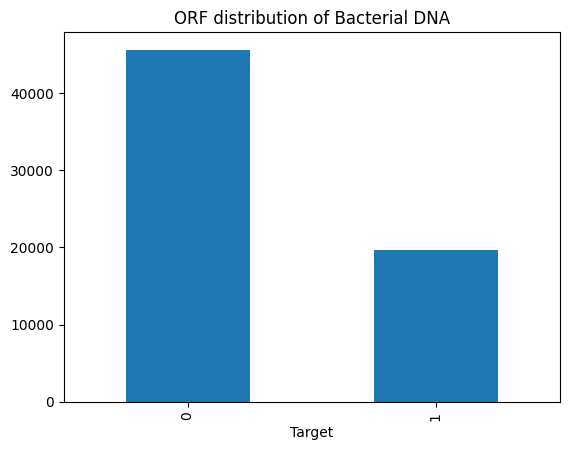

In [7]:
df['Target'].value_counts().sort_index().plot.bar()
plt.title("ORF distribution of Bacterial DNA");

In [8]:
def kmers_funct(seq, size=6):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]

In [9]:
df['DNA_sequence'] = df.apply(lambda x: kmers_funct(x['DNA_sequence']), axis=1)

/tmp/ipykernel_34/3880847245.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DNA_sequence'] = df.apply(lambda x: kmers_funct(x['DNA_sequence']), axis=1)


In [10]:
df.head()

,DNA_sequence,Target
60455,"[gctcac, ctcacg, tcacgc, cacgcg, acgcgc, cgcgc...",0
49650,"[gagctc, agctca, gctcac, ctcacc, tcaccc, caccc...",0
31043,"[cacctg, acctgc, cctgcc, ctgccc, tgcccg, gcccg...",0
42092,"[gctacg, ctacga, tacgaa, acgaac, cgaact, gaact...",0
10200,"[gtcgcg, tcgcgc, cgcgcg, gcgcgc, cgcgct, gcgct...",1


## Determination of Variables

In [11]:
X = df['DNA_sequence'].values   
y = df['Target'].values

## Data Preprocessing 

In [12]:
tokenizer = Tokenizer(num_words=None)

In [13]:
tokenizer.fit_on_texts(X)

In [14]:
X_num_tokens = tokenizer.texts_to_sequences(X)

In [15]:
X_pad = pad_sequences(X_num_tokens, maxlen=1000)

In [16]:
X_pad.shape

(65321, 1000)

In [17]:
y.shape

(65321,)

## Train Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, 
                                                    y, 
                                                    test_size = 0.1,
                                                    stratify = y,
                                                    random_state=1)

## SMOTE

In [19]:
sm = SMOTE(random_state=1)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [20]:
embedding_size = 100
num_words = 10000

## GRU

In [21]:
model = Sequential()
model.add(Embedding(input_dim=num_words,        
                    output_dim=embedding_size))    
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(units=48, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(units=24, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(units=12)))
model.add(Dense(1, activation='sigmoid'))

In [22]:
optimizer = Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['Recall'])

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
early_stop = EarlyStopping(monitor="val_Recall", mode="max",         
                           verbose=1, patience = 20, restore_best_weights=True)

In [25]:
model_history = model.fit(X_train, y_train, epochs=50, batch_size=1024,
                          validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 71s 772ms/step - Recall: 0.5673 - loss: 0.6679 - val_Recall: 0.0933 - val_loss: 0.6163
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 782ms/step - Recall: 0.6033 - loss: 0.4298 - val_Recall: 0.0639 - val_loss: 0.5816
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 779ms/step - Recall: 0.6842 - loss: 0.3990 - val_Recall: 0.0857 - val_loss: 0.5758
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 778ms/step - Recall: 0.7109 - loss: 0.3827 - val_Recall: 0.3134 - val_loss: 0.5807
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 779ms/step - Recall: 0.7409 - loss: 0.3705 - val_Recall: 0.2738 - val_loss: 0.5820
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 779ms/step - Recall: 0.7584 - loss: 0.3558 - val_Recall: 0.2485 - val_loss: 0.6028
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 780ms/step - Recall: 0.7788 - loss: 0.3418 - val_Recall: 0.3159 - val_loss: 0.6180
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 779ms/step - Recall: 0.8020 - loss: 0.3208 - val_Recall: 0.2566 - val_loss: 0.6275


## GRU Model Evaluation

In [26]:
y_train_pred = model.predict(X_train) >= 0.5
print(confusion_matrix(y_train, y_train_pred))
print("-------------------------------------------------------")
print(classification_report(y_train, y_train_pred))

2566/2566 ━━━━━━━━━━━━━━━━━━━━ 149s 58ms/step
[[37880  3162]
 [ 3450 37592]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     41042
           1       0.92      0.92      0.92     41042

    accuracy                           0.92     82084
   macro avg       0.92      0.92      0.92     82084
weighted avg       0.92      0.92      0.92     82084



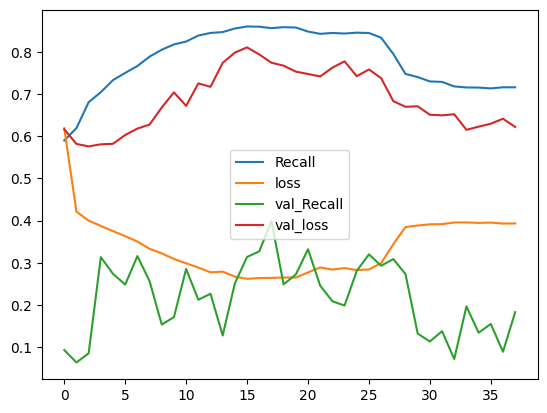

In [27]:
pd.DataFrame(model_history.history).plot();

## LSTM

In [28]:
model = Sequential()
model.add(Embedding(input_dim=num_words,        
                    output_dim=embedding_size))    
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=48, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=24, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=12)))
model.add(Dense(1, activation='sigmoid'))

In [29]:
optimizer = Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['Recall'])

In [30]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
early_stop = EarlyStopping(monitor="val_Recall", mode="max",         
                           verbose=1, patience = 20, restore_best_weights=True)

In [32]:
model_history = model.fit(X_train, y_train, epochs=50, batch_size=1024,
                          validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 69s 782ms/step - Recall: 0.5904 - loss: 0.6701 - val_Recall: 0.6968 - val_loss: 0.6952
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 773ms/step - Recall: 0.4167 - loss: 0.6812 - val_Recall: 0.0096 - val_loss: 0.6135
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 773ms/step - Recall: 0.5725 - loss: 0.4666 - val_Recall: 0.0000e+00 - val_loss: 0.5927
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 774ms/step - Recall: 0.6015 - loss: 0.4282 - val_Recall: 0.0010 - val_loss: 0.5988
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 773ms/step - Recall: 0.6183 - loss: 0.4164 - val_Recall: 0.0314 - val_loss: 0.5814
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 774ms/step - Recall: 0.6449 - loss: 0.4101 - val_Recall: 0.2880 - val_loss: 0.5742
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 774ms/step - Recall: 0.7040 - loss: 0.4011 - val_Recall: 0.1435 - val_loss: 0.5756
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 774ms/step - Recall: 0.7069 - loss: 0.3946 - val_Recall: 0.2104 - val_loss: 0.5

## LSTM Model Evaluation

In [33]:
y_train_pred = model.predict(X_train) >= 0.5
print(confusion_matrix(y_train, y_train_pred))
print("-------------------------------------------------------")
print(classification_report(y_train, y_train_pred))

2566/2566 ━━━━━━━━━━━━━━━━━━━━ 149s 58ms/step
[[14663 26379]
 [ 9672 31370]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.60      0.36      0.45     41042
           1       0.54      0.76      0.64     41042

    accuracy                           0.56     82084
   macro avg       0.57      0.56      0.54     82084
weighted avg       0.57      0.56      0.54     82084



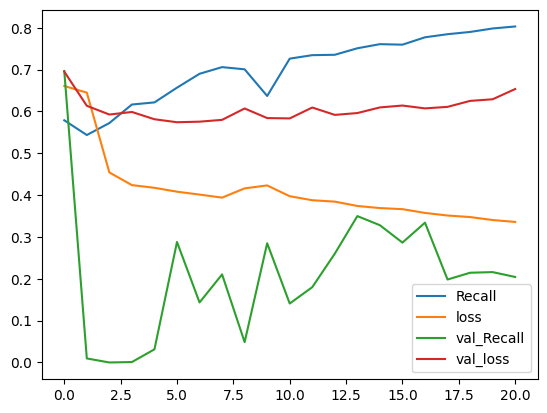

In [34]:
pd.DataFrame(model_history.history).plot();